# Looking for the smartest algorithm in the room

Machine Learning practice with the **Enron** Email Corpus and Financial Dataset.

---

Katie's enthusiasm is contractible, so I went ahead to learn a bit. Watching the documentary allowed me to learn quite some new things about that ugly side of the _American Dream_.

Here's to some more involvement through a different path.

## What is this about?
Using Machine Learning techniques, I will try to analyze the two combined datasets to try to predict who of the people that are part of the dataset might be persons of interest (poi).
I define a poi to be someone who might be worth further investigation, because he or she might be more closely involved in the Enron fraud case than other people who worked at the company at that time.

One feature that these predictions will be based on, is the label 'poi', that was manually assembled by Katie Malone from people proven to be involved in the fraud. (Source: http://usatoday30.usatoday.com/money/industries/energy/2005-12-28-enron-participants_x.htm)
It therefore represents a key feature for the analysis.


In [1]:
#!/usr/bin/python

import sys
import pickle
import pprint
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

## Selecting Features
### Selection Mechanism
At first I wanted to know how often do I actually have data for the respective features, so I coded this up.
Initially I wanted to consider only features that are shared by at least 60% of the people in the dataset (where `feature != 'NaN'`). However, this did not include any data of the Email Corpus, so I reduced the treshold to 50%.

In [2]:
### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

###
### 1 - SELECTING FEATURES
###

# a dict with the basic structure of the data, to keep count of occurences
count_dict = {'bonus': 0,
 'deferral_payments': 0,
 'deferred_income': 0,
 'director_fees': 0,
 'email_address': 0,
 'exercised_stock_options': 0,
 'expenses': 0,
 'from_messages': 0,
 'from_poi_to_this_person': 0,
 'from_this_person_to_poi': 0,
 'loan_advances': 0,
 'long_term_incentive': 0,
 'other': 0,
 'poi': 0,
 'restricted_stock': 0,
 'restricted_stock_deferred': 0,
 'salary': 0,
 'shared_receipt_with_poi': 0,
 'to_messages': 0,
 'total_payments': 0,
 'total_stock_value': 0}
# to see which features are present for many people, i count
for person, p_dict in data_dict.items():
	for key, value in p_dict.items():
		if value != "NaN":
			count_dict[key] += 1
# for better comparison i will use the percentage of total
amount_people = len(data_dict)
perc_dict = {}
for key, value in count_dict.items():
	perc_dict[key] = round((value * 100.0) / amount_people, 2)
#pprint.pprint(perc_dict)
# filtering for the more common features, with a treshhold of 50%
common_feature_list = []
for key, value in perc_dict.items():
	if value >= 50:
		common_feature_list.append(key)

# removing features I don't want to investigate (for justification
# see the ML_report_Enron file)
remove_list = ['to_messages', 'exercised_stock_options', 'email_address',
			'total_stock_value', 'expenses', 'from_messages', 'other', 'restricted_stock']
features_list = [feature for index, feature in enumerate(common_feature_list) if feature not in remove_list]
# ordering 'poi' to index = 0
features_list = features_list[4:] + features_list[:4]
pprint.pprint(features_list)

['poi',
 'shared_receipt_with_poi',
 'from_poi_to_this_person',
 'salary',
 'total_payments',
 'bonus',
 'from_this_person_to_poi']


Of the result:

```python
['salary', 'to_messages', 'total_payments', 'exercised_stock_options', 'bonus', 'email_address', 'total_stock_value', 'expenses', 'from_messages', 'other', 'from_this_person_to_poi', 'poi', 'shared_receipt_with_poi', 'restricted_stock', 'from_poi_to_this_person']
```

I selected

```python
['poi', 'salary', 'bonus', 'total_payments', 'shared_receipt_with_poi', 'from_poi_to_this_person', 'from_this_person_to_poi' ]
```


#### out
'email_address' is a unique string for each person and therefore won't have any predictive power. 'to_messages' and 'from_messages' seems better encoded in 'from_poi_to_this_person' and 'from_this_person_to_poi', considering that I will explore the data in correlation to pois (persons of interest).
I don't even know what 'other' is, and neither am I familiar with 'restricted_stock' and 'exercised_stock_options'.
I can probably understand 'total_stock_value', however I know that high-ranking pois were selling off their stocks of the company towards the end, and I just generally don't know enough about the stock market to handle these values well. I also am unsure about what 'expenses' are logged in the so-named variable, so for this analysis I kept it aside.


#### in
What I therefore chose to further investigate and train my classifiers on, is 'salary', 'bonus' and 'total_payments', for the more obvious financial-related features. Further I chose 'from_poi_to_this_person' and 'from_this_person_to_poi' from the email corpus data, to investigate a possible relationship indicated of pois sending an increased amount of emails between each other than towards non-pois.
And finally I also chose 'shared_receipt_with_poi' from the financial dataset. This is another more exploratoy feature, but it got me interested to look for trends here (and to properly understand what does this mean).


### Other Considerations
I decided not to employ a Decision Tree algorithm for selecting my features. My main reason for this was, that even though some now-discarded feature might do a good job in predicting pois, I found it dangerous to base this on features that have less than half of the data involved.
With 146 people, the dataset is anyways not very large, therefore I wanted to make sure to train and test my algorithms at least on a somewhat representable size.

In [3]:
# preparing a pandas DF for easier access
import pandas as pd

enron_df = pd.DataFrame(data_dict)
# better in the other format
enron_df = enron_df.transpose()

# reducing the dataframe for better overview
for c in enron_df.columns:
    if c not in features_list:
        enron_df.drop(c, axis=1, inplace=True)
enron_df.head()

,bonus,from_poi_to_this_person,from_this_person_to_poi,poi,salary,shared_receipt_with_poi,total_payments
ALLEN PHILLIP K,4175000,47,65,False,201955,1407,4484442
BADUM JAMES P,NaN,NaN,NaN,False,NaN,NaN,182466
BANNANTINE JAMES M,NaN,39,0,False,477,465,916197
BAXTER JOHN C,1200000,NaN,NaN,False,267102,NaN,5634343
BAY FRANKLIN R,400000,NaN,NaN,False,239671,NaN,827696


## Outliers?
Checking whether all is sound in the data.

/Applications/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


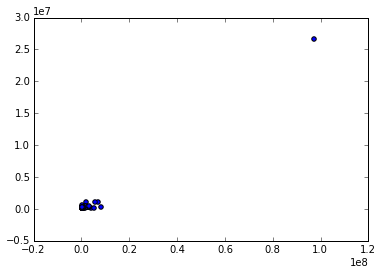

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.scatter(enron_df['bonus'], enron_df['salary'])

Gotcha! Let's take a closer loook at this one all the way up there!

I had a little trouble here when trying to find the `max()` value of the columns. The code only returned me `NaN` as the max. After a while I figured that this is because the `'NaN'` values were actually **strings**, not `None` type. Here I figured this out and went ahead to transform them into actual `NaN`.

In [5]:
print type(enron_df['salary'][1])

<type 'str'>


In [6]:
enron_df['salary'].isnull().head()

ALLEN PHILLIP K       False
BADUM JAMES P         False
BANNANTINE JAMES M    False
BAXTER JOHN C         False
BAY FRANKLIN R        False
Name: salary, dtype: bool

In [7]:
enron_df.replace(['NaN'], [None], inplace=True)
enron_df.head()

,bonus,from_poi_to_this_person,from_this_person_to_poi,poi,salary,shared_receipt_with_poi,total_payments
ALLEN PHILLIP K,4175000,47,65,False,201955,1407,4484442
BADUM JAMES P,NaN,NaN,NaN,False,NaN,NaN,182466
BANNANTINE JAMES M,NaN,39,0,False,477,465,916197
BAXTER JOHN C,1200000,NaN,NaN,False,267102,NaN,5634343
BAY FRANKLIN R,400000,NaN,NaN,False,239671,NaN,827696


In [8]:
enron_df['salary'].isnull().head()

ALLEN PHILLIP K       False
BADUM JAMES P          True
BANNANTINE JAMES M    False
BAXTER JOHN C         False
BAY FRANKLIN R        False
Name: salary, dtype: bool

Okay, with that out of the way, I can finally target my outlier.

In [9]:
outlier = enron_df['salary'].max()

In [10]:
print enron_df.loc[enron_df['salary'] == outlier]

          bonus  from_poi_to_this_person  from_this_person_to_poi    poi  \
TOTAL  97343619                      NaN                      NaN  False   

         salary  shared_receipt_with_poi  total_payments  
TOTAL  26704229                      NaN       309886585  


Yep. "Mr. Total" was not one of the main players in the fraud - this row can be safely removed.

In [11]:
enron_df = enron_df[enron_df.salary != outlier]
enron_df.head()

,bonus,from_poi_to_this_person,from_this_person_to_poi,poi,salary,shared_receipt_with_poi,total_payments
ALLEN PHILLIP K,4175000,47,65,False,201955,1407,4484442
BADUM JAMES P,NaN,NaN,NaN,False,NaN,NaN,182466
BANNANTINE JAMES M,NaN,39,0,False,477,465,916197
BAXTER JOHN C,1200000,NaN,NaN,False,267102,NaN,5634343
BAY FRANKLIN R,400000,NaN,NaN,False,239671,NaN,827696


In [12]:
print enron_df['salary'].max()

1111258.0


This looks more "reasonable". Let's give it up for the graphic.

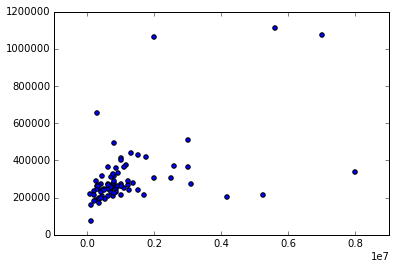

In [13]:
plt.scatter(enron_df['bonus'], enron_df['salary'])

Even though these remaining sums seem highly overpriced as well, these ones are most likely outliers of interest (oois). Some people got a lot of money.

In [14]:
# checking also the minimum
min_outlier = enron_df.salary.min()
print enron_df.loc[enron_df.salary == min_outlier]

                    bonus  from_poi_to_this_person  from_this_person_to_poi  \
BANNANTINE JAMES M    NaN                       39                        0   

                      poi  salary  shared_receipt_with_poi  total_payments  
BANNANTINE JAMES M  False     477                      465          916197  


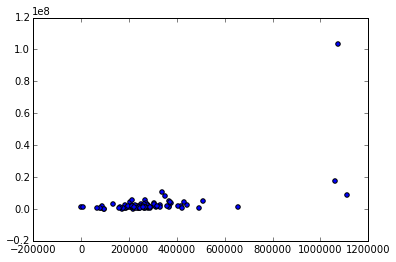

In [15]:
plt.scatter(enron_df.salary, enron_df.total_payments)

Another lone rider here, however he might be real...

In [16]:
outlier = enron_df.total_payments.max()
print enron_df.loc[enron_df.total_payments == outlier]

                 bonus  from_poi_to_this_person  from_this_person_to_poi  \
LAY KENNETH L  7000000                      123                       16   

                poi   salary  shared_receipt_with_poi  total_payments  
LAY KENNETH L  True  1072321                     2411       103559793  


Yep... That's one of our men...

In [17]:
# checking also the minimum
min_outlier = enron_df.total_payments.min()
print enron_df.loc[enron_df.total_payments == min_outlier]

                 bonus  from_poi_to_this_person  from_this_person_to_poi  \
MENDELSOHN JOHN    NaN                      NaN                      NaN   

                   poi  salary  shared_receipt_with_poi  total_payments  
MENDELSOHN JOHN  False     NaN                      NaN             148  


This person seems not very useful for doing any predictions, considering that he has only one value filled (`total payments`). I will run a test to remove rows that have >= 50% of my chosen features missing.

Let's take a look at the rest of the data.

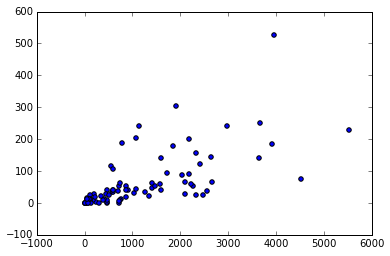

In [18]:
plt.scatter(enron_df.shared_receipt_with_poi, enron_df.from_poi_to_this_person)

In [19]:
def display_outlier(column_name):
    outlier = enron_df[column_name].max()
    print enron_df.loc[enron_df[column_name] == outlier]
    
display_outlier('shared_receipt_with_poi')

                    bonus  from_poi_to_this_person  from_this_person_to_poi  \
BELDEN TIMOTHY N  5249999                      228                      108   

                   poi  salary  shared_receipt_with_poi  total_payments  
BELDEN TIMOTHY N  True  213999                     5521         5501630  


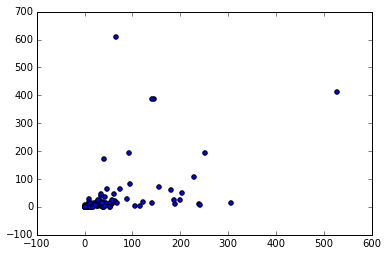

In [20]:
plt.scatter(enron_df.from_poi_to_this_person, enron_df.from_this_person_to_poi)

In [21]:
display_outlier('from_poi_to_this_person')
display_outlier('from_this_person_to_poi')

                   bonus  from_poi_to_this_person  from_this_person_to_poi  \
LAVORATO JOHN J  8000000                      528                      411   

                   poi  salary  shared_receipt_with_poi  total_payments  
LAVORATO JOHN J  False  339288                     3962        10425757  
                    bonus  from_poi_to_this_person  from_this_person_to_poi  \
DELAINEY DAVID W  3000000                       66                      609   

                   poi  salary  shared_receipt_with_poi  total_payments  
DELAINEY DAVID W  True  365163                     2097         4747979  


Yep, the rest is all to keep. Outlier detection terminated.

### Removing (near) empty rows
Because scarce data is probably not very useful for prediction, I will remove rows that have >= 50% data missing of my chosen features.

In [22]:
print "number of rows before removing those with scarce feature data:", len(enron_df)
more_than_half_features = len(features_list) - len(features_list) / 2
enron_df.dropna(axis='index', thresh=more_than_half_features, inplace=True)
print "number of rows after removing those with scarce feature data:",  len(enron_df)

number of rows before removing those with scarce feature data: 145
number of rows after removing those with scarce feature data: 106


## A new feature

In [23]:
enron_df.head()

,bonus,from_poi_to_this_person,from_this_person_to_poi,poi,salary,shared_receipt_with_poi,total_payments
ALLEN PHILLIP K,4175000,47,65,False,201955,1407,4484442
BANNANTINE JAMES M,NaN,39,0,False,477,465,916197
BAXTER JOHN C,1200000,NaN,NaN,False,267102,NaN,5634343
BAY FRANKLIN R,400000,NaN,NaN,False,239671,NaN,827696
BECK SALLY W,700000,144,386,False,231330,2639,969068


In [24]:
def email_perc(row):
    one_way = row['from_this_person_to_poi']
    the_other = row['from_poi_to_this_person']
    
    ratio = 0
    if one_way != 0 and the_other != 0:
        ratio = float(one_way) / the_other
    return ratio

In [25]:
enron_df["sent_received_ratio"] = enron_df.apply(lambda row: email_perc(row), axis=1)
enron_df.head()

,bonus,from_poi_to_this_person,from_this_person_to_poi,poi,salary,shared_receipt_with_poi,total_payments,sent_received_ratio
ALLEN PHILLIP K,4175000,47,65,False,201955,1407,4484442,1.382979
BANNANTINE JAMES M,NaN,39,0,False,477,465,916197,0.000000
BAXTER JOHN C,1200000,NaN,NaN,False,267102,NaN,5634343,NaN
BAY FRANKLIN R,400000,NaN,NaN,False,239671,NaN,827696,NaN
BECK SALLY W,700000,144,386,False,231330,2639,969068,2.680556


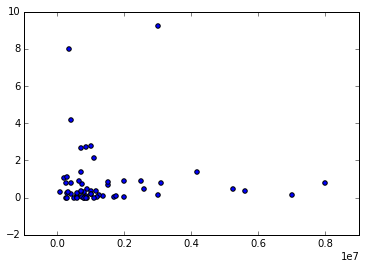

In [26]:
plt.scatter(enron_df.bonus, enron_df.sent_received_ratio)
# c=lambda x: "red" if (enron_df.poi == True) else "blue"

In [27]:
display_outlier('sent_received_ratio')

                    bonus  from_poi_to_this_person  from_this_person_to_poi  \
DELAINEY DAVID W  3000000                       66                      609   

                   poi  salary  shared_receipt_with_poi  total_payments  \
DELAINEY DAVID W  True  365163                     2097         4747979   

                  sent_received_ratio  
DELAINEY DAVID W             9.227273  


Seems I'll need a non-empty-value dataset for building my classifiers. `0` would work, however this would be false information because for the `NaN` values there is actually now record, and not a `0` record.

In [28]:
enron_no_na = enron_df.dropna()
enron_no_na.head()

,bonus,from_poi_to_this_person,from_this_person_to_poi,poi,salary,shared_receipt_with_poi,total_payments,sent_received_ratio
ALLEN PHILLIP K,4175000,47,65,False,201955,1407,4484442,1.382979
BECK SALLY W,700000,144,386,False,231330,2639,969068,2.680556
BELDEN TIMOTHY N,5249999,228,108,True,213999,5521,5501630,0.473684
BERGSIEKER RICHARD P,250000,4,0,False,187922,233,618850,0.000000
BIBI PHILIPPE A,1000000,23,8,False,213625,1336,2047593,0.347826


In [29]:
# reformat the pandas df to a dict, for further processing with the lesson code
my_dataset = enron_df.to_dict(orient='index')
no_na_dataset = enron_no_na.to_dict(orient='index')
median_dataset = enron_df.fillna(enron_df.median().to_dict()).to_dict(orient='index')

print my_dataset['METTS MARK'], '\n'
print no_na_dataset['METTS MARK'], '\n'
print median_dataset['ALLEN PHILLIP K']

{'salary': 365788.0, 'sent_received_ratio': 0.02631578947368421, 'total_payments': 1061827.0, 'bonus': 600000.0, 'shared_receipt_with_poi': 702.0, 'from_this_person_to_poi': 1.0, 'poi': False, 'from_poi_to_this_person': 38.0} 

{'salary': 365788.0, 'sent_received_ratio': 0.02631578947368421, 'total_payments': 1061827.0, 'bonus': 600000.0, 'shared_receipt_with_poi': 702.0, 'from_this_person_to_poi': 1.0, 'poi': False, 'from_poi_to_this_person': 38.0} 

{'salary': 201955.0, 'sent_received_ratio': 1.3829787234042554, 'total_payments': 4484442.0, 'bonus': 4175000.0, 'shared_receipt_with_poi': 1407.0, 'from_this_person_to_poi': 65.0, 'poi': False, 'from_poi_to_this_person': 47.0}


Here I'll be choosing the final features_list, that will exclude the two features `from_this_person_to_poi` and `from_poi_to_this_person`, and instead include the newly created ratio `sent_received_ratio`.

In [30]:
features_list.remove('from_this_person_to_poi')
features_list.remove('from_poi_to_this_person')

In [31]:
print features_list

['poi', 'shared_receipt_with_poi', 'salary', 'total_payments', 'bonus']


In [32]:
### Extract features and labels from datasets for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

# creating a dataset without NaN values (removing the rows that contain NaN)
no_na_data = featureFormat(no_na_dataset, features_list, sort_keys = True)
no_na_labels, no_na_features = targetFeatureSplit(no_na_data)

# creating a dataset with NaN replaced by the median
median_data = featureFormat(median_dataset, features_list, sort_keys = True)
median_labels, median_features = targetFeatureSplit(median_data)

## Classifiers

Splitting my data into test and training data. I'll be using 30% of the data for testing purposes.

Because there are a bunch of `NaN` values in the dataset, I tried to versions of analysis with my dataset:

1. removing the rows that contain `NaN` values
2. filling them with the **median**

I decided for the median over the mean, because **outliers** (in the form of at least the already identified pois) are present and important to the data and the prediction. When using the mean on the now-empty values, these outliers would severly alter the distribution. Therefore I chose the median, because it is resisting outlier-influence.

In [33]:
from sklearn.cross_validation import train_test_split

# features without filtering
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.3, random_state=42)
# features filtered, NaN values removed
no_na_features_train, no_na_features_test, no_na_labels_train, no_na_labels_test = train_test_split(no_na_features, no_na_labels, test_size=0.3, random_state=42)
# features filtered, NaN replaced with the median
median_features_train, median_features_test, median_labels_train, median_labels_test = train_test_split(median_features, median_labels, test_size=0.3, random_state=42)

# creating lists:
full_feat_list = [features_train, features_test, labels_train, labels_test]
no_na_list = [no_na_features_train, no_na_features_test, no_na_labels_train, no_na_labels_test]
median_list = [median_features_train, median_features_test, median_labels_train, median_labels_test]

In [34]:
def test_classifier(classifier_obj, data, scale=False):
    """Measures the time and accuracy of a given classifier.
    
    Takes as input a classifiert object (tuned or untuned)
    and a list containing the training and testing features and labels
    in this form:
    data = [features_train, features_test, labels_train, labels_test]
    Prints processing time and overall accuracy score.
    """
    from time import time
    from sklearn.metrics import accuracy_score
    from sklearn.preprocessing import MinMaxScaler
    
    # scaling the data when the type of algorithm demands this
    if scale == True:
        scaler = MinMaxScaler()
        features_train = scaler.fit_transform(data[0])
        features_test = scaler.transform(data[1])
    else:
        features_train = data[0]
        features_test = data[1]
    labels_train = data[2]
    labels_test = data[3]
    
    # taking the time the algorithm runs
    t0 = time()
    classifier_obj.fit(features_train, labels_train)
    print "training time:", round(time()-t0, 3), "s"
    
    # taking time for prediction
    t1 = time()
    pred = classifier_obj.predict(features_test)
    print "predicting time:", round(time()-t1, 3), "s"
    
    acc = accuracy_score(labels_test, pred)
    print "accuracy:", acc
    
    print construct_CM(labels_test, pred)
    print calculate_f1(labels_test, pred)

In [35]:
def get_CM_nums(true_labels, predictions, CM_type):
    """Calculates the number of elements in the different cells of a confusion matrix.

    Takes as input the true labels and the predictions, both as lists.
    Further a specification of the metric wanted as an abbreviated string:
    'TP' for True Positives, 'FP' for False Positives
    'TN' for True Negatives, 'FN' for False Negatives
    Returns the amount of the specified metric.
    """
    import numpy as np
    
    if CM_type == "TP" or CM_type == "TN":
        if CM_type == "TP":
            CM_type = 1
        elif CM_type == "TN":
            CM_type = 0
        cpp = [1 for j in zip(true_labels, predictions) if j[0] == j[1] and j[1] == CM_type]
    elif CM_type == "FP" or CM_type == "FN":
        if CM_type == "FP":
            CM_type = 1
        elif CM_type == "FN":
            CM_type = 0
        cpp = [1 for j in zip(true_labels, predictions) if j[0] != j[1] and j[1] == CM_type]
    else:
        print "error, please enter TP, TN, FP, or FN."
    num_cpp = np.sum(cpp)
    return int(num_cpp)

def construct_CM(true_labels, predictions):
    """Wrapper function to calculate the confusion matrix and returns a formatted string.

    Takes as input the true labels and the predictions, both as lists.
    Calls get_CM_nums() with all possible inputs (TP, FP, TN, FN)
    Returns a formatted string representing the confusion martrix that is easy to read.
    """
    num_TP = get_CM_nums(true_labels, predictions, "TP")
    num_TN = get_CM_nums(true_labels, predictions, "TN")
    num_FP = get_CM_nums(true_labels, predictions, "FP")
    num_FN = get_CM_nums(true_labels, predictions, "FN")

    return """confusion matrix:                  
              predicted class
              _Yes_|__No_
actual | Yes |  {0}  |  {3}
class  | No  |  {2}  |  {1}""".format(num_TP, num_TN, num_FP, num_FN)

def calculate_f1(true_labels, predictions):
    """Calculates statistical metrics for the classifier's prediction.
    
    Takes as input the true labels and the predictions, both as lists.
    Returns a string containing the scores for precision recall and the f1-score.
    """
    from sklearn.metrics import precision_score
    from sklearn.metrics import recall_score
    from sklearn.metrics import f1_score
    
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    f1_score =  f1_score(true_labels, predictions)
    return """precision: {0}
recall:    {1}
f1_score:  {2}""".format(precision, recall, f1_score)

### Naive Bayes

In [36]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
test_classifier(clf, no_na_list)

training time: 0.001 s
predicting time: 0.0 s
accuracy: 0.684210526316
confusion matrix:                  
              predicted class
              _Yes_|__No_
actual | Yes |  1  |  4
class  | No  |  2  |  12
precision: 0.333333333333
recall:    0.2
f1_score:  0.25


#### HIGHEST NAIVE BAYES

In [37]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
test_classifier(clf, median_list)

training time: 0.002 s
predicting time: 0.0 s
accuracy: 0.75
confusion matrix:                  
              predicted class
              _Yes_|__No_
actual | Yes |  0  |  6
class  | No  |  2  |  24
precision: 0.0
recall:    0.0
f1_score:  0.0


Oh! this is the best so far! substituting with the median seems to have helped.
However... what happens to **booleans** when you call a median() on them?!

In [38]:
enron_df.poi.median()

0.0

Okay, seems to be okay, it returns `0.0`, which should be interpreted as `False`. Also, all the values for poi should actually be filled in.

### SVM

In [39]:
from sklearn.svm import SVC

# 'rbf' is the default kernel used
clf = SVC()
test_classifier(clf, no_na_list, scale=True)

training time: 0.001 s
predicting time: 0.0 s
accuracy: 0.736842105263
confusion matrix:                  
              predicted class
              _Yes_|__No_
actual | Yes |  0  |  5
class  | No  |  0  |  14
precision: 0.0
recall:    0.0
f1_score:  0.0


/Applications/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Applications/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [40]:
from sklearn.svm import SVC

# 'rbf' is the default kernel used
clf = SVC()
test_classifier(clf, median_list, scale=True)

training time: 0.001 s
predicting time: 0.0 s
accuracy: 0.8125
confusion matrix:                  
              predicted class
              _Yes_|__No_
actual | Yes |  0  |  6
class  | No  |  0  |  26
precision: 0.0
recall:    0.0
f1_score:  0.0


In [41]:
# ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’

from sklearn.svm import SVC

# running with 'linear' went on so long that I ended up terminating the process
# and "precomputed" returned an error

clf = SVC(kernel="sigmoid")
test_classifier(clf, no_na_list, scale=True)

training time: 0.0 s
predicting time: 0.0 s
accuracy: 0.736842105263
confusion matrix:                  
              predicted class
              _Yes_|__No_
actual | Yes |  0  |  5
class  | No  |  0  |  14
precision: 0.0
recall:    0.0
f1_score:  0.0


In [42]:
from sklearn.svm import SVC

clf = SVC(kernel="sigmoid")
test_classifier(clf, median_list, scale=True)

training time: 0.001 s
predicting time: 0.0 s
accuracy: 0.8125
confusion matrix:                  
              predicted class
              _Yes_|__No_
actual | Yes |  0  |  6
class  | No  |  0  |  26
precision: 0.0
recall:    0.0
f1_score:  0.0


### Decision Trees

In [43]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
test_classifier(clf, no_na_list)

training time: 0.001 s
predicting time: 0.003 s
accuracy: 0.578947368421
confusion matrix:                  
              predicted class
              _Yes_|__No_
actual | Yes |  1  |  4
class  | No  |  4  |  10
precision: 0.2
recall:    0.2
f1_score:  0.2


In [44]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
test_classifier(clf, median_list)

training time: 0.001 s
predicting time: 0.0 s
accuracy: 0.6875
confusion matrix:                  
              predicted class
              _Yes_|__No_
actual | Yes |  0  |  6
class  | No  |  4  |  22
precision: 0.0
recall:    0.0
f1_score:  0.0


In [45]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_features="sqrt")
test_classifier(clf, no_na_list)

training time: 0.001 s
predicting time: 0.0 s
accuracy: 0.684210526316
confusion matrix:                  
              predicted class
              _Yes_|__No_
actual | Yes |  2  |  3
class  | No  |  3  |  11
precision: 0.4
recall:    0.4
f1_score:  0.4


In [46]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_features="sqrt")
test_classifier(clf, median_list)

training time: 0.001 s
predicting time: 0.0 s
accuracy: 0.75
confusion matrix:                  
              predicted class
              _Yes_|__No_
actual | Yes |  2  |  4
class  | No  |  4  |  22
precision: 0.333333333333
recall:    0.333333333333
f1_score:  0.333333333333


In [47]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_features="log2")
test_classifier(clf, no_na_list)

training time: 0.001 s
predicting time: 0.0 s
accuracy: 0.526315789474
confusion matrix:                  
              predicted class
              _Yes_|__No_
actual | Yes |  1  |  4
class  | No  |  5  |  9
precision: 0.166666666667
recall:    0.2
f1_score:  0.181818181818


In [48]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_features="log2")
test_classifier(clf, median_list)

training time: 0.001 s
predicting time: 0.0 s
accuracy: 0.71875
confusion matrix:                  
              predicted class
              _Yes_|__No_
actual | Yes |  0  |  6
class  | No  |  3  |  23
precision: 0.0
recall:    0.0
f1_score:  0.0


Oh, reducing the amount of features increases the accurcacy quite some.

In [49]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_features=1)
test_classifier(clf, no_na_list)

training time: 0.001 s
predicting time: 0.0 s
accuracy: 0.578947368421
confusion matrix:                  
              predicted class
              _Yes_|__No_
actual | Yes |  2  |  3
class  | No  |  5  |  9
precision: 0.285714285714
recall:    0.4
f1_score:  0.333333333333


In [50]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_features=1)
test_classifier(clf, median_list)

training time: 0.001 s
predicting time: 0.0 s
accuracy: 0.71875
confusion matrix:                  
              predicted class
              _Yes_|__No_
actual | Yes |  1  |  5
class  | No  |  4  |  22
precision: 0.2
recall:    0.166666666667
f1_score:  0.181818181818


### K-nearest Neighbours

In [51]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier()
test_classifier(neigh, no_na_list, scale=True)

training time: 0.001 s
predicting time: 0.001 s
accuracy: 0.736842105263
confusion matrix:                  
              predicted class
              _Yes_|__No_
actual | Yes |  0  |  5
class  | No  |  0  |  14
precision: 0.0
recall:    0.0
f1_score:  0.0


In [52]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier()
test_classifier(neigh, median_list, scale=True)

training time: 0.0 s
predicting time: 0.001 s
accuracy: 0.78125
confusion matrix:                  
              predicted class
              _Yes_|__No_
actual | Yes |  0  |  6
class  | No  |  1  |  25
precision: 0.0
recall:    0.0
f1_score:  0.0


In [53]:
neigh = KNeighborsClassifier(n_neighbors=1)
test_classifier(neigh, no_na_list, scale=True)

training time: 0.0 s
predicting time: 0.001 s
accuracy: 0.684210526316
confusion matrix:                  
              predicted class
              _Yes_|__No_
actual | Yes |  2  |  3
class  | No  |  3  |  11
precision: 0.4
recall:    0.4
f1_score:  0.4


In [54]:
neigh = KNeighborsClassifier(n_neighbors=1)
test_classifier(neigh, median_list, scale=True)

training time: 0.001 s
predicting time: 0.001 s
accuracy: 0.71875
confusion matrix:                  
              predicted class
              _Yes_|__No_
actual | Yes |  0  |  6
class  | No  |  3  |  23
precision: 0.0
recall:    0.0
f1_score:  0.0


Strange: it shows a lower accuracy at `n_neighbors=1`, but caps at `0.736842105263` starting from `n_neighbors=2`.
Not quite sure why that's the case.

In [55]:
from testalot import test_a_lot

In [56]:
def test_a_lot(training_test_list):
	from sklearn.naive_bayes import GaussianNB
	from sklearn.svm import SVC
	from sklearn.tree import DecisionTreeClassifier
	from sklearn.neighbors import KNeighborsClassifier

	print "PERFORMANCE RESULTS OF DIFFERENT CLASSIFIERS"

	### Naive Bayes
	print "\n\n\n### NAIVE BAYES ###"
	clf = GaussianNB()
	test_classifier(clf, training_test_list)


	### Support Vector Machines
	print "\n\n\n### SUPPORT VECTOR MACHINES ###"
	# 'rbf' is the default kernel used
	print "# with 'rbf' kernel"
	clf = SVC()
	test_classifier(clf, training_test_list, scale=True)
	print '\n'

	# 'sigmoid'
	print "# with 'sigmoid' kernel"
	clf = SVC(kernel="sigmoid")
	test_classifier(clf, training_test_list, scale=True)


	### Decision Trees
	print "\n\n\n### DECISION TREES ###"
	# 'max_features' default is None = n_features
	print "# using all features"
	clf = DecisionTreeClassifier()
	test_classifier(clf, training_test_list)
	print '\n'

	# 'sqrt'
	print "# using the square root of the features"
	clf = DecisionTreeClassifier(max_features="sqrt")
	test_classifier(clf, training_test_list)
	print '\n'

	# 'log2'
	print "# using the log2 of the features"
	clf = DecisionTreeClassifier(max_features="log2")
	test_classifier(clf, training_test_list)
	print '\n'

	# 1
	print "# using 1 feature"
	clf = DecisionTreeClassifier(max_features=1)
	test_classifier(clf, training_test_list)


	### K-nearest Neighbours
	print "\n\n\n### K-NEAREST NEIGHBORS ###"
	# 'n_neighbors' defaUlt is 5
	print "# with k = 5"
	neigh = KNeighborsClassifier()
	test_classifier(neigh, training_test_list, scale=True)
	print '\n'

	# 1
	print "# with k = 1"
	neigh = KNeighborsClassifier(n_neighbors=1)
	test_classifier(neigh, training_test_list, scale=True)

In [57]:
test_a_lot(no_na_list)

PERFORMANCE RESULTS OF DIFFERENT CLASSIFIERS



### NAIVE BAYES ###
training time: 0.001 s
predicting time: 0.0 s
accuracy: 0.684210526316
confusion matrix:                  
              predicted class
              _Yes_|__No_
actual | Yes |  1  |  4
class  | No  |  2  |  12
precision: 0.333333333333
recall:    0.2
f1_score:  0.25



### SUPPORT VECTOR MACHINES ###
# with 'rbf' kernel
training time: 0.0 s
predicting time: 0.0 s
accuracy: 0.736842105263
confusion matrix:                  
              predicted class
              _Yes_|__No_
actual | Yes |  0  |  5
class  | No  |  0  |  14
precision: 0.0
recall:    0.0
f1_score:  0.0


# with 'sigmoid' kernel
training time: 0.0 s
predicting time: 0.0 s
accuracy: 0.736842105263
confusion matrix:                  
              predicted class
              _Yes_|__No_
actual | Yes |  0  |  5
class  | No  |  0  |  14
precision: 0.0
recall:    0.0
f1_score:  0.0



### DECISION TREES ###
# using all features
training time: 0.002 s
pr

In [58]:
test_a_lot(median_list)

PERFORMANCE RESULTS OF DIFFERENT CLASSIFIERS



### NAIVE BAYES ###
training time: 0.001 s
predicting time: 0.0 s
accuracy: 0.75
confusion matrix:                  
              predicted class
              _Yes_|__No_
actual | Yes |  0  |  6
class  | No  |  2  |  24
precision: 0.0
recall:    0.0
f1_score:  0.0



### SUPPORT VECTOR MACHINES ###
# with 'rbf' kernel
training time: 0.001 s
predicting time: 0.0 s
accuracy: 0.8125
confusion matrix:                  
              predicted class
              _Yes_|__No_
actual | Yes |  0  |  6
class  | No  |  0  |  26
precision: 0.0
recall:    0.0
f1_score:  0.0


# with 'sigmoid' kernel
training time: 0.001 s
predicting time: 0.0 s
accuracy: 0.8125
confusion matrix:                  
              predicted class
              _Yes_|__No_
actual | Yes |  0  |  6
class  | No  |  0  |  26
precision: 0.0
recall:    0.0
f1_score:  0.0



### DECISION TREES ###
# using all features
training time: 0.0 s
predicting time: 0.0 s
accuracy: 0.718

Calculate precision and recall and other stats related to the confusion matrix

In [59]:
import math
# amount of features for best estimate
best_feat_num = math.log(6, 2)
print int(best_feat_num)

2


In [62]:
int(math.sqrt(6))

2